In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dask.distributed import LocalCluster, Client

from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider
import lab.functions as func

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import SlidingWindowSplitter, ExpandingWindowSplitter, temporal_train_test_split
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error, MeanAbsoluteScaledError, mean_absolute_scaled_error

SEED=0
np.random.seed(SEED)

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [6]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

investingdotcom_tickers = ["DAILY_TTF_PRICE", "MONTHLY_TTF_PRICE"]
investingdotcom_provider = GenericDataProvider("datalake/clean/investingdotcom/", want_metadata=False, tickers=investingdotcom_tickers)
print(investingdotcom_tickers)

marketwatch_tickers = ["DAILY_COAL_PRICE"]
marketwatch_provider = GenericDataProvider("datalake/clean/marketwatch/", want_metadata=False, tickers=marketwatch_tickers)
print(marketwatch_tickers)

icap_tickers = ["CO2_EUA_PRICE"]
icap_provider = GenericDataProvider("datalake/clean/ICAP/", want_metadata=False, tickers=icap_tickers)
print(icap_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']
['DAILY_TTF_PRICE', 'MONTHLY_TTF_PRICE']
['DAILY_COAL_PRICE']
['CO2_EUA_PRICE']


In [18]:
forecasting_horizon = 30
fh = list(range(1, forecasting_horizon+1))

nb_windows = 30
step_size = 1

regressor_list = [DummyRegressor(), KNeighborsRegressor(), RandomForestRegressor(random_state=SEED),
                      GradientBoostingRegressor(random_state=SEED), SVR()]
regressor_str_list = ["DummyRegressor", "KNeighborsRegressor", "RandomForestRegressor", "GradientBoostingRegressor", "SVR"]

In [22]:
def load_and_preprocess_daily_data(start_index, end_index):
    esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", start_index=start_index, end_index=end_index, resample_by="D", group_mode="mean")
    esios_df = esios_provider.get_all_series(freq="H", start_index=start_index, end_index=end_index, resample_by="D", group_mode="sum")
    ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[0], freq="D", start_index=start_index, end_index=end_index)
    coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", start_index=start_index, end_index=end_index)
    co2_df = icap_provider.get_series(icap_tickers[0], freq="D", start_index=start_index, end_index=end_index)

    contamination = 0.01
    esios_df = func.remove_outliers_isolation_forests(esios_df, contamination)

    X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
    X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)
    lags = [2, 6, 7, 13, 14, 28, 30, 31]
    date_features = ["day", "day_of_week", "week_of_year", "month"]

    df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)
    y_date_features = df_date_features.iloc[:, 0]
    X_date_features = df_date_features.iloc[:, 1:]

    y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test = temporal_train_test_split(y_date_features, X_date_features, test_size=forecasting_horizon)

    window_length = (len(y_date_features_train) - step_size * (nb_windows - 1)) - forecasting_horizon

    return y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test, window_length

## Postpandemic

### 6 months dataset

In [29]:
y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test, window_length = load_and_preprocess_daily_data(start_index="2021-04-01", end_index="2023-03-31")
print(window_length)

610


In [31]:
cv_results_df = func.crossval_model_sktime(y_date_features_train, X_date_features_train, regressor_list, regressor_str_list, window_length, max_lag=1, step_size=step_size, fh=1, save_path="lab/models/daily/", save_name="2y_20w_1step_30.1fh_9pred_mase.pkl")

Training setup: regressor DummyRegressor
Training setup: regressor KNeighborsRegressor
Training setup: regressor RandomForestRegressor


KeyboardInterrupt: 

In [9]:
save_path = "lab/models/daily/"
cv_results_df = pd.read_pickle(save_path+"2y_20w_1step_30.1fh_9pred_mase.pkl")

In [10]:
cv_results_df_summary = func.crossval_summary_sktime(cv_results_df)
cv_results_df_summary

model          mae      mase    fit_time
4                        SVR   872.517005   2.35961   18.531466
2      RandomForestRegressor   874.994406  2.363738  475.145427
0             DummyRegressor   967.368608  2.615814    0.312892
3  GradientBoostingRegressor  1005.814414  2.717971  286.673593
1        KNeighborsRegressor  1052.429117  2.846196     0.70964

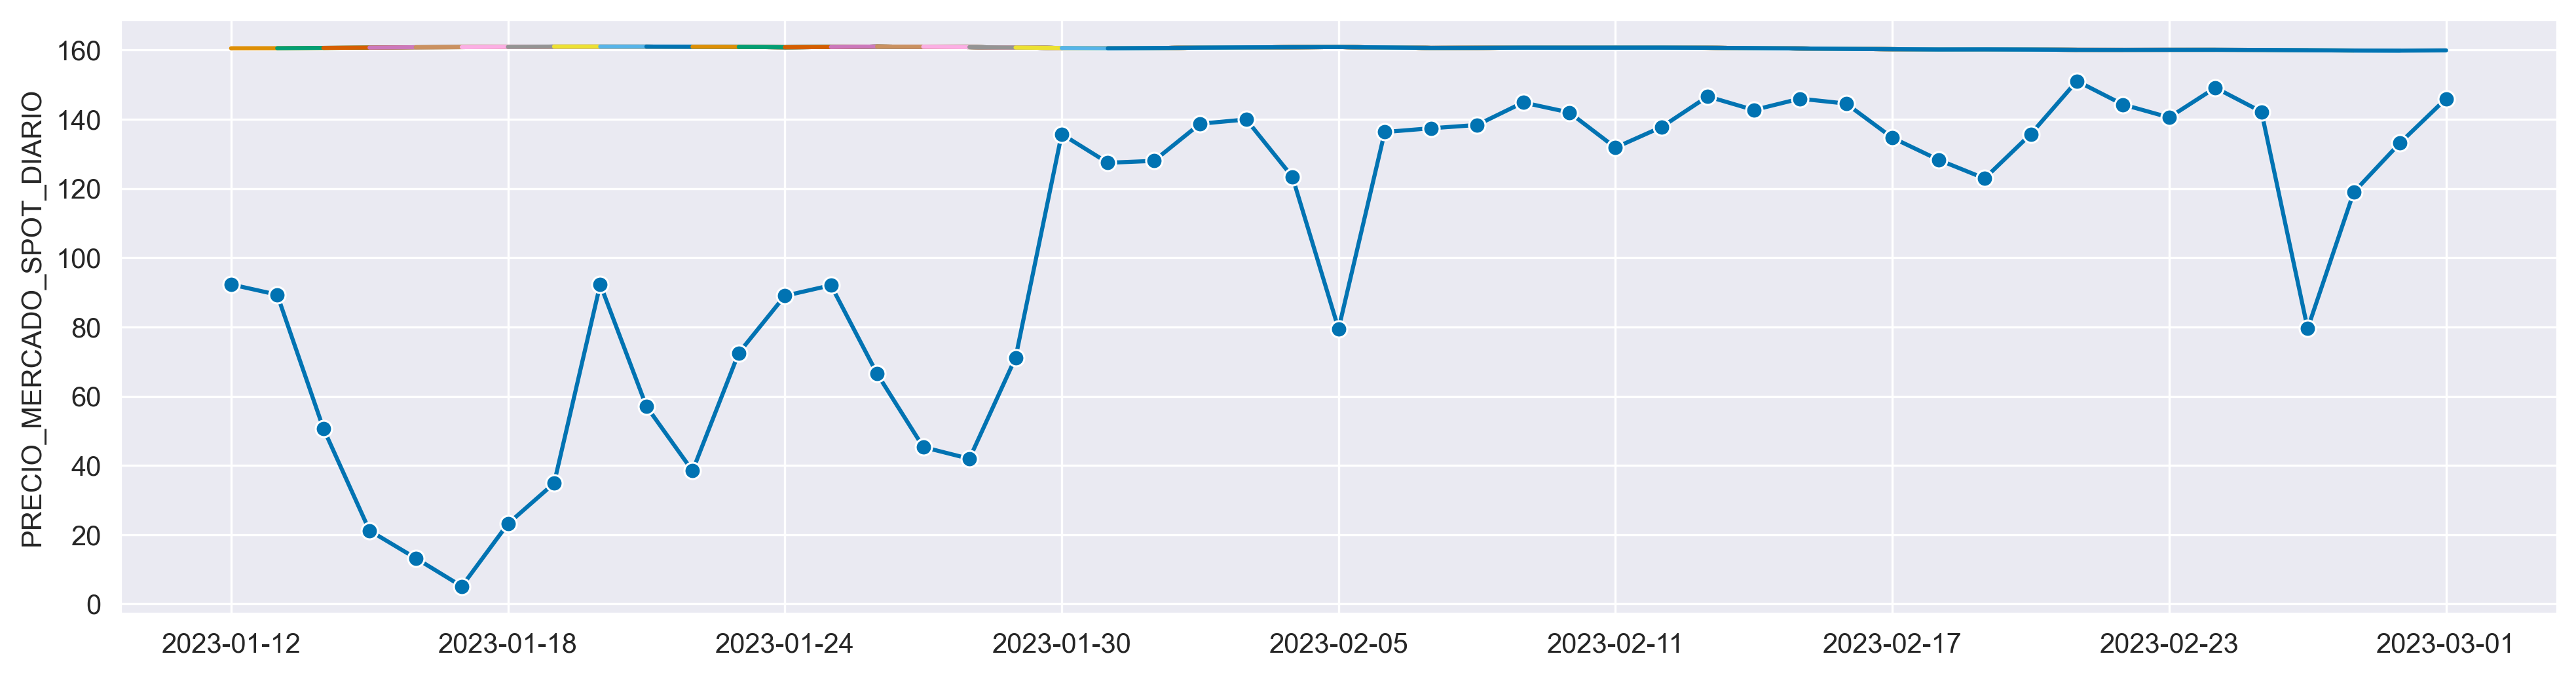

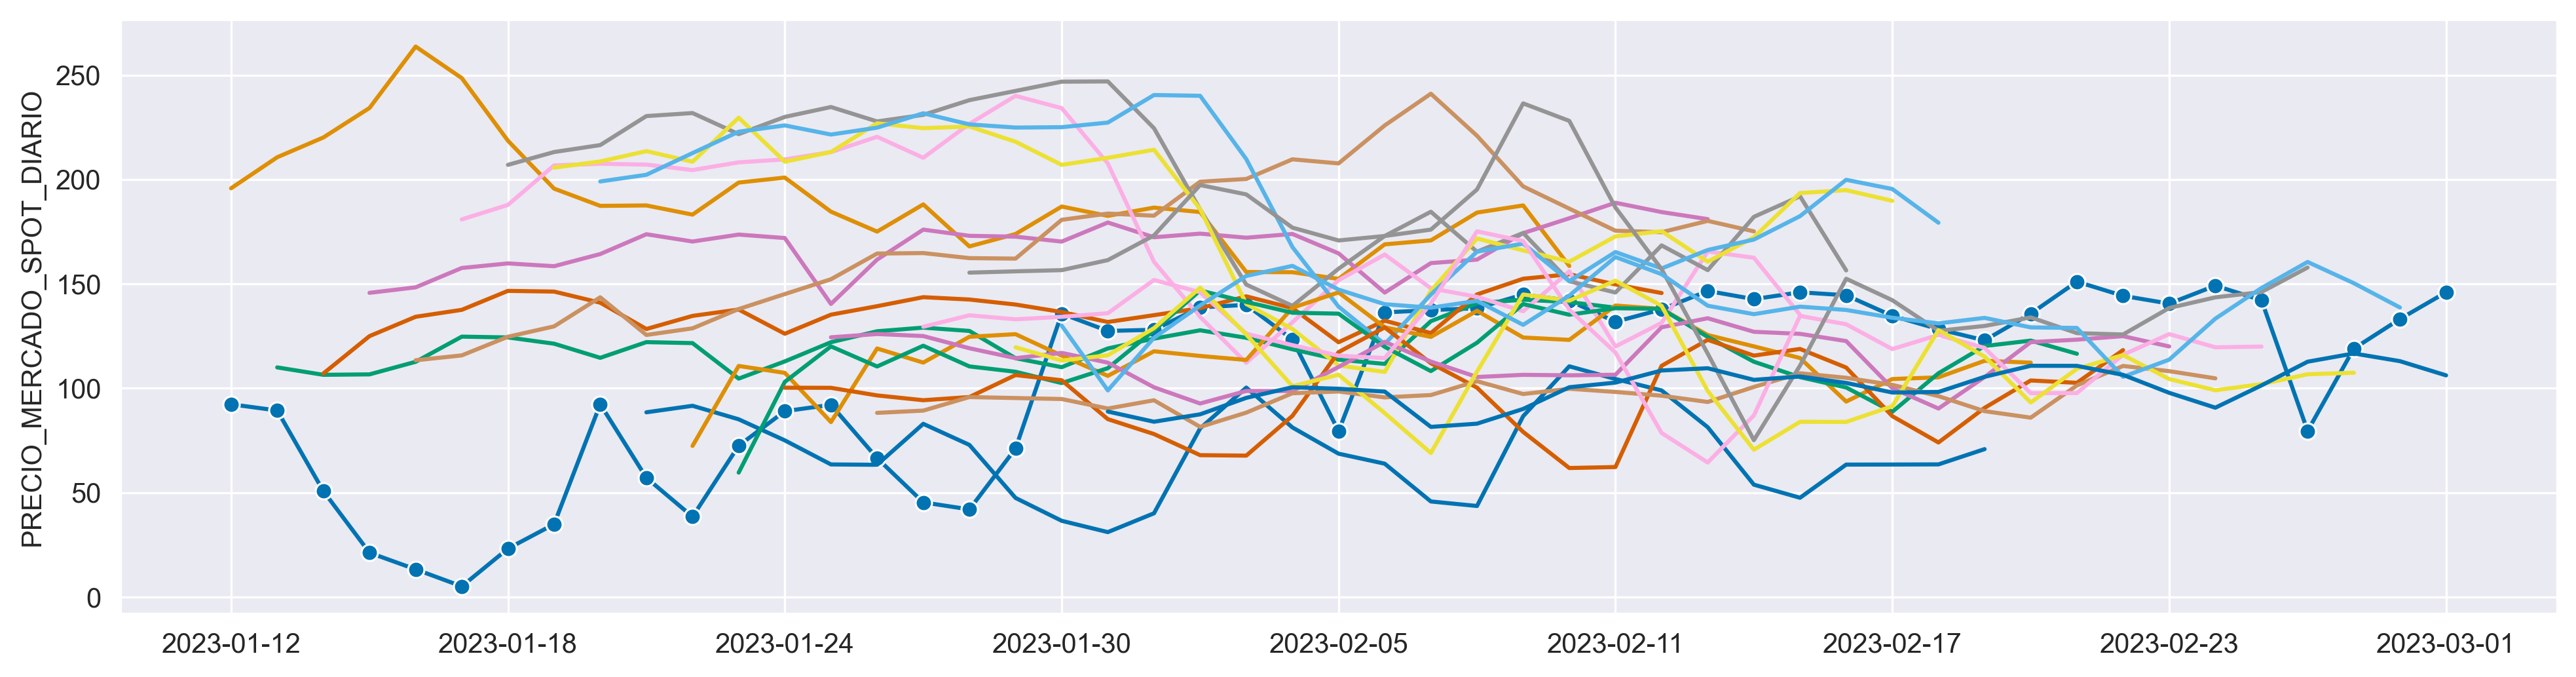

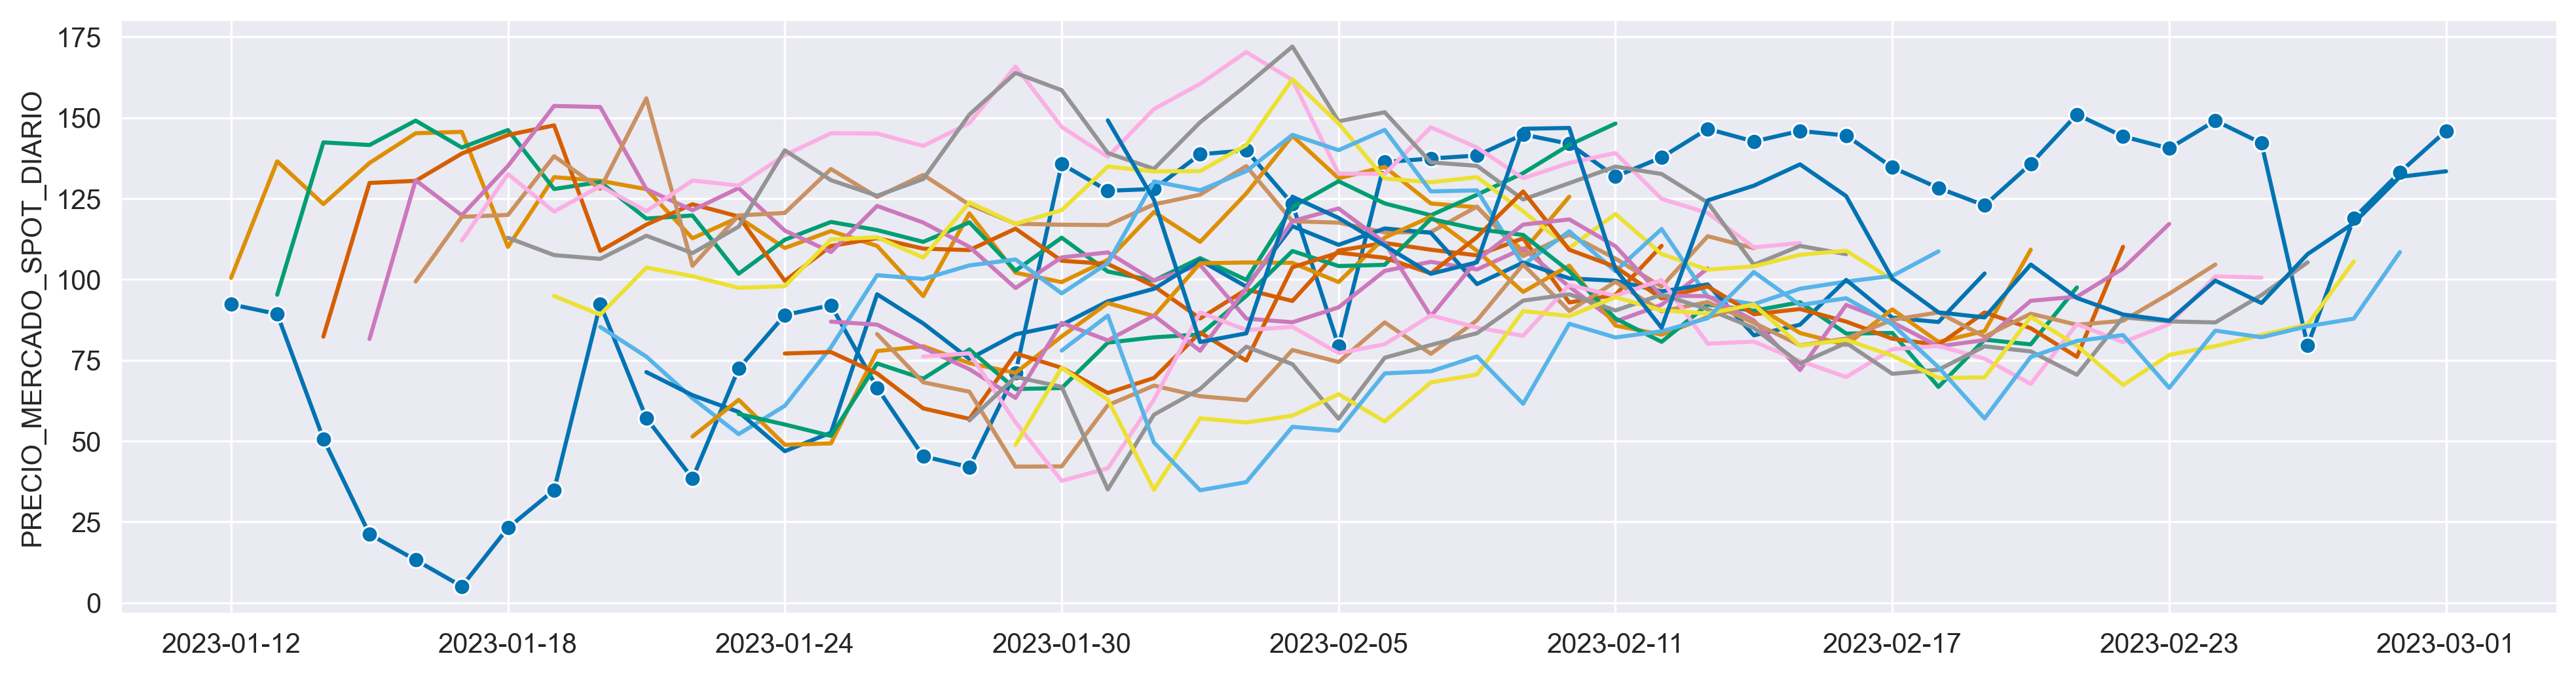

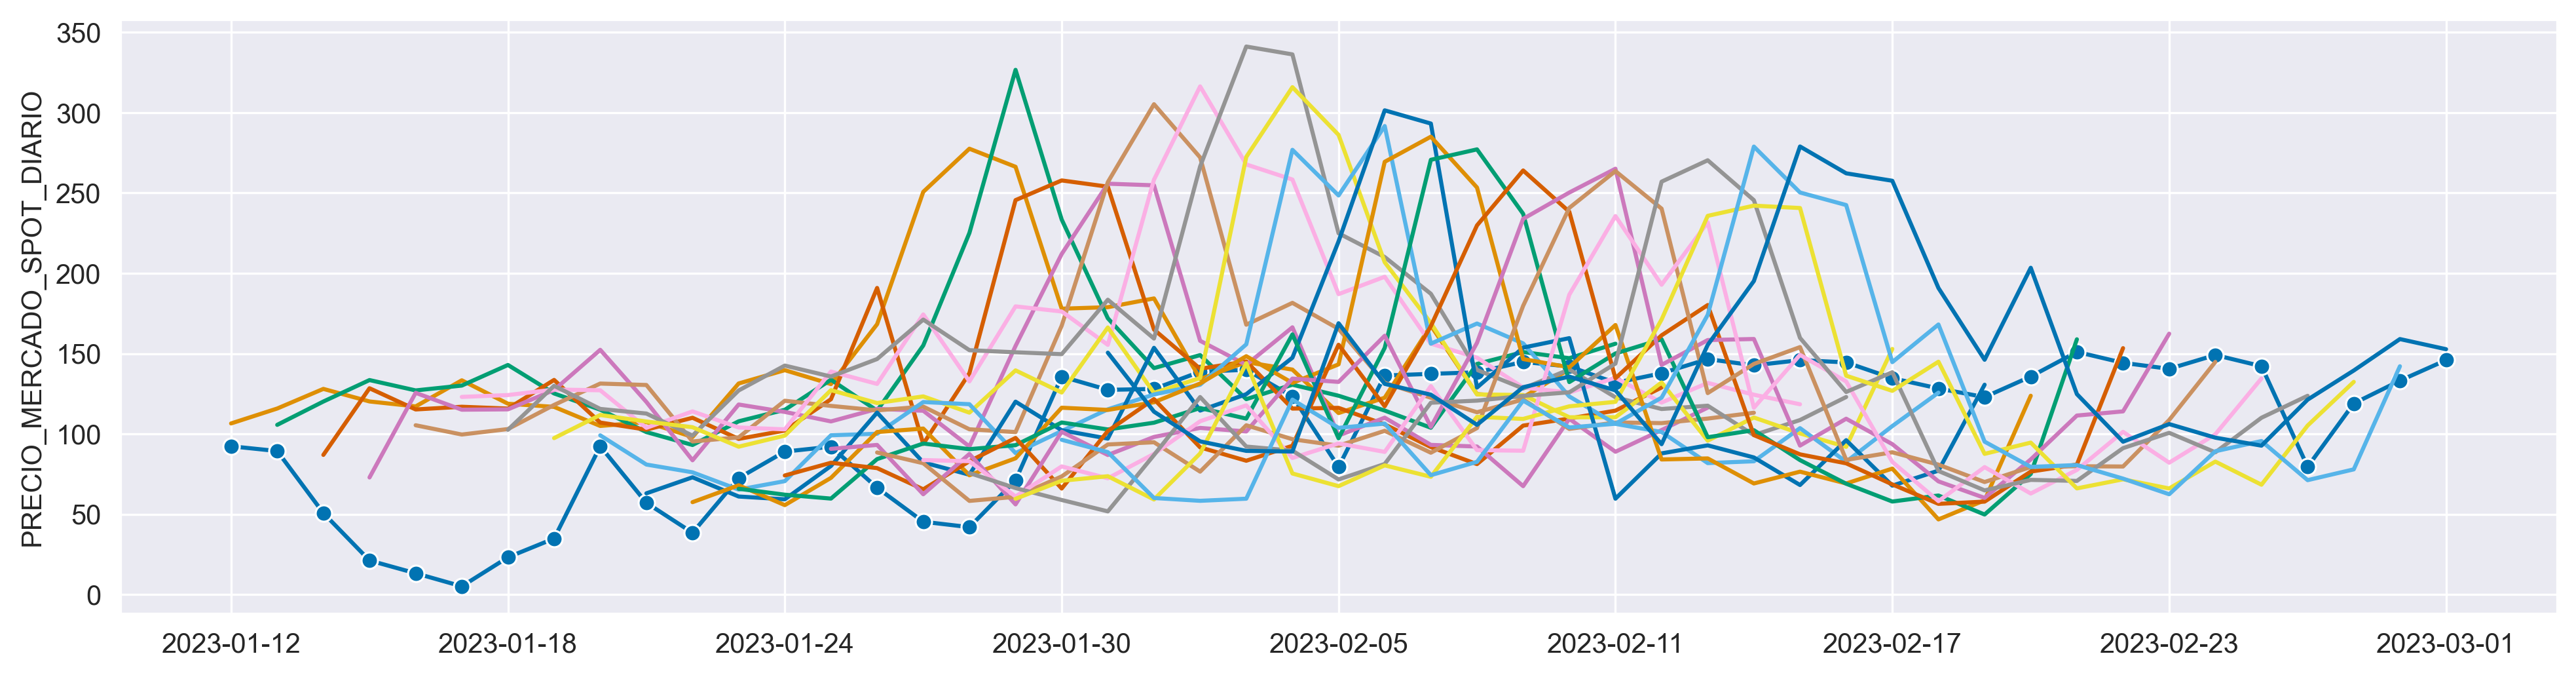

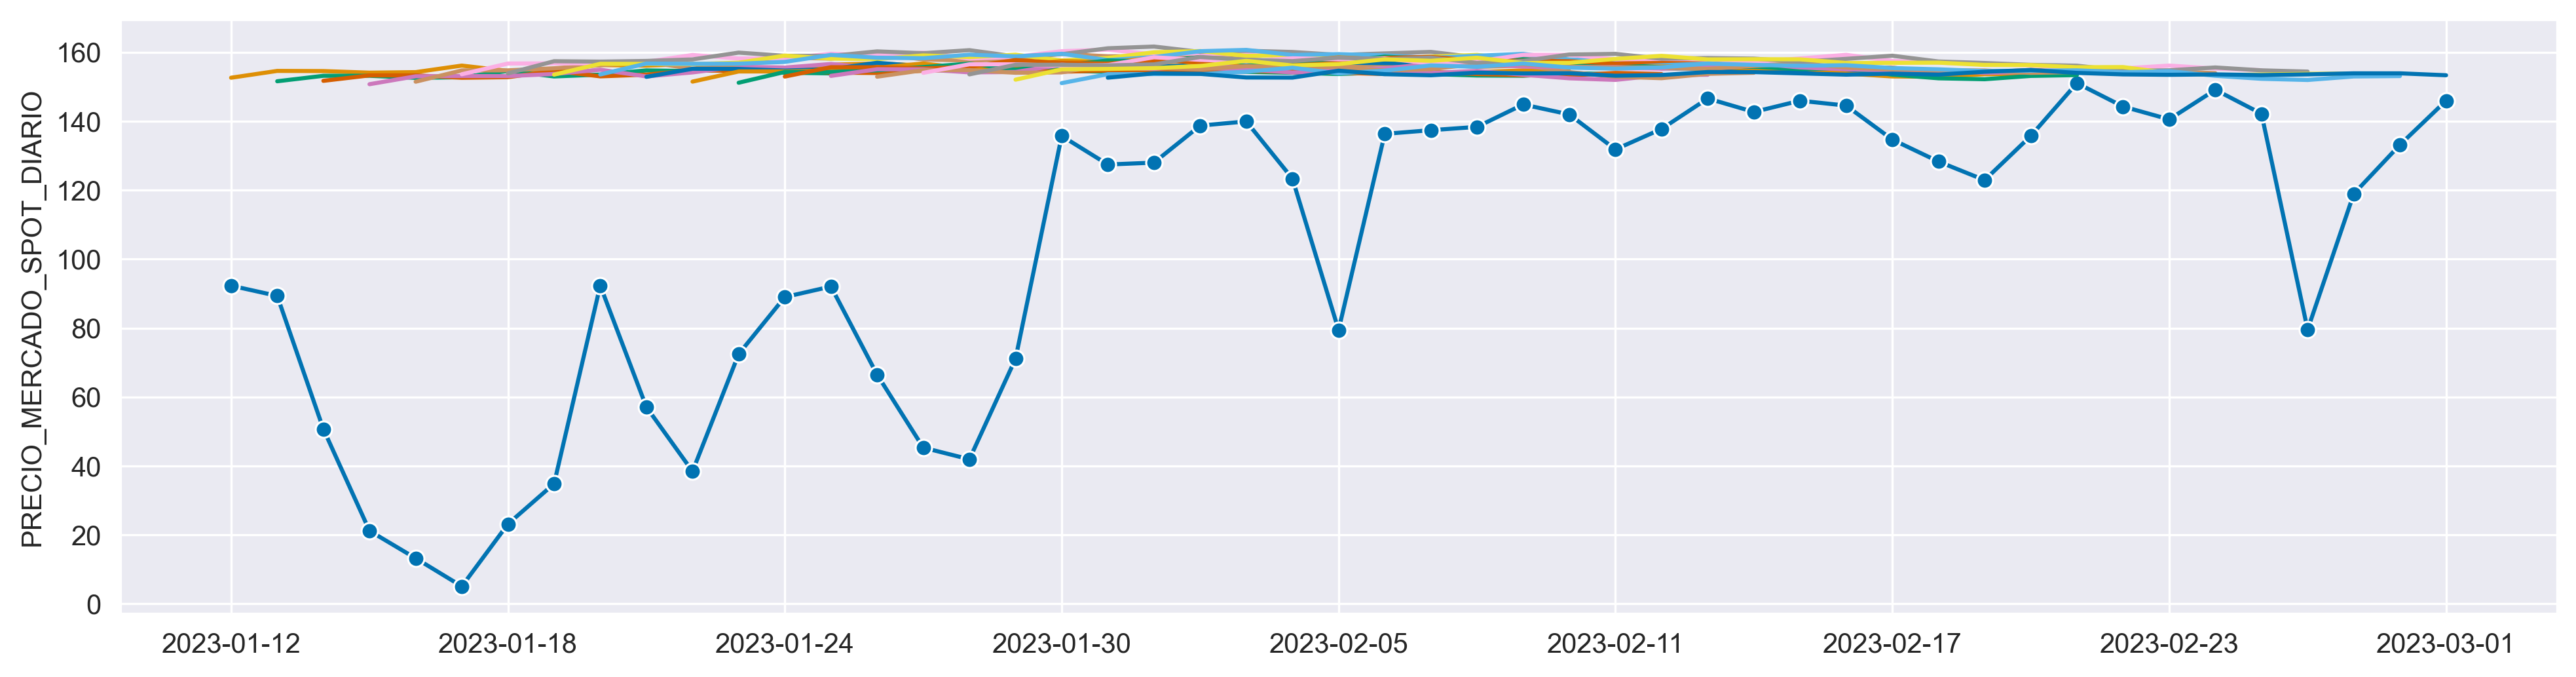

In [11]:
func.crossval_plot_series(y_date_features_train[window_length:], cv_results_df)

#### Final model

88.96028333333334
1.7901660242712267
4.861990421524967


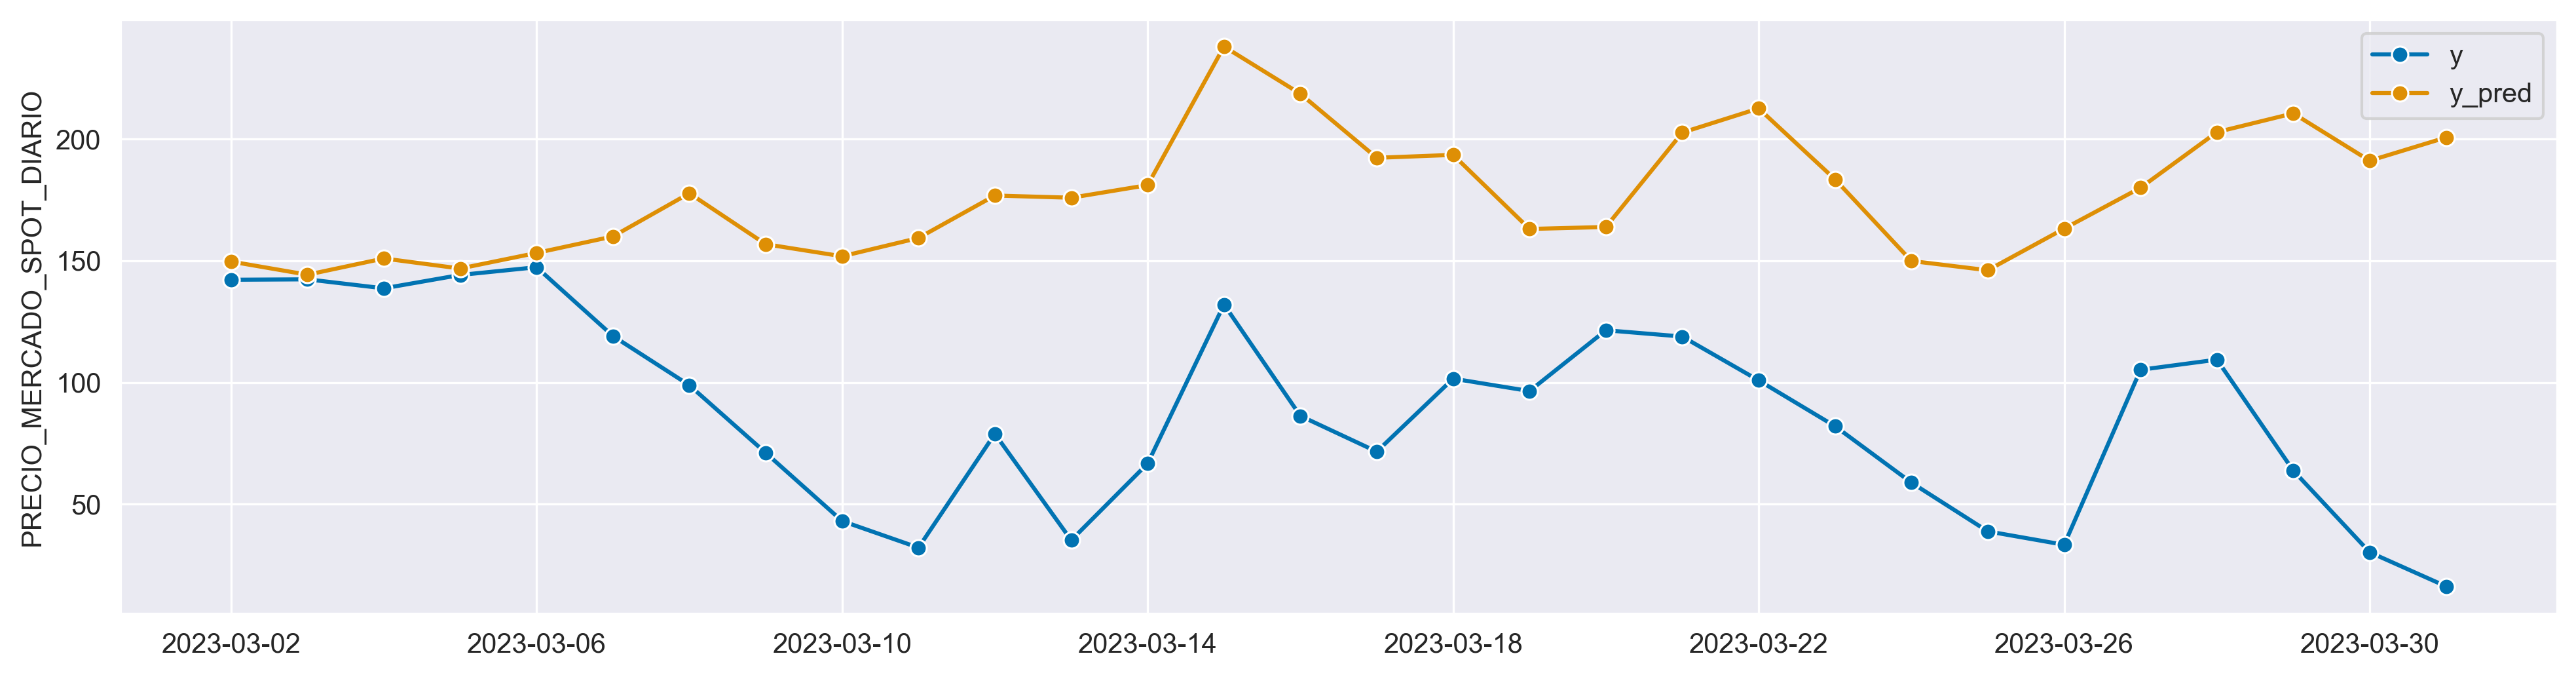

In [12]:
best_model_string = cv_results_df_summary.iloc[1, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]
#best_model = GradientBoostingRegressor(random_state=0)

forecaster = make_reduction(best_model, strategy="direct", window_length=1, windows_identical=True)
forecaster.fit(y_date_features_train, X=X_date_features_train, fh=list(range(1, forecasting_horizon + 1)))

y_pred = forecaster.predict(X=X_date_features_test)
plot_series(y_date_features_test, y_pred, labels=["y", "y_pred"])
print(mean_absolute_error(y_date_features_test, y_pred))
print(mean_absolute_percentage_error(y_date_features_test, y_pred))
print(mean_absolute_scaled_error(y_date_features_test, y_pred, y_train=y_date_features_train))

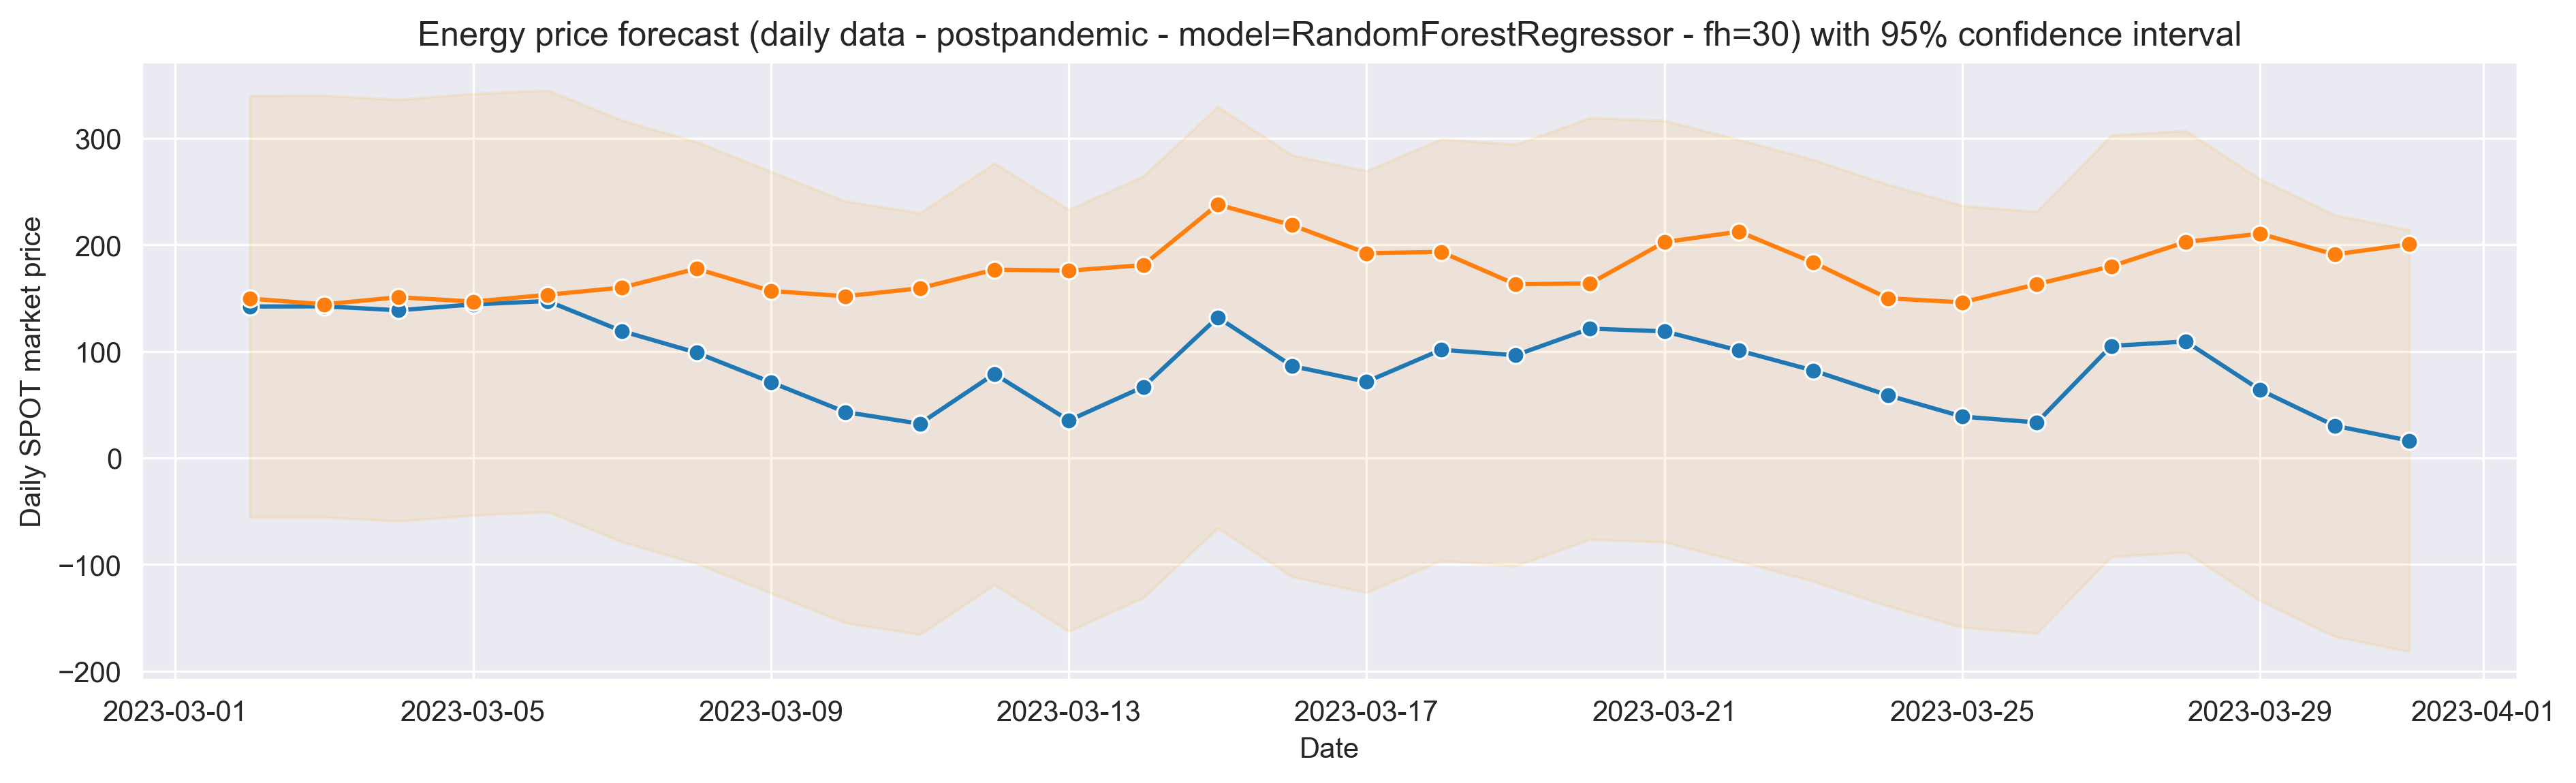

In [13]:
residuals = abs(y_pred-y_date_features_test)
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

if type(y_date_features_test.index) is pd.core.indexes.period.PeriodIndex:
    y_date_features_test.index = y_date_features_test.index.to_timestamp()
if type(y_pred.index) is pd.core.indexes.period.PeriodIndex:
    y_pred.index = y_pred.index.to_timestamp()

fig, ax = plt.subplots(figsize=(15,4))
sns.lineplot(data=y_date_features_test, palette="deepskyblue", marker="o", ax=ax)
sns.lineplot(data=y_pred, palette="orange", marker="o", ax=ax)
ax.fill_between(y_date_features_test.index, (y_date_features_test-band_size), (y_date_features_test+band_size), color='orange', alpha=.1)
ax.set_title(f"Energy price forecast (daily data - postpandemic - model={best_model_string} - fh={forecasting_horizon}) with 95% confidence interval")
ax.set_xlabel('Date')
ax.set_ylabel('Daily SPOT market price')
plt.show()

## Prepandemic

### 6 months dataset

In [14]:
y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test, window_length = load_and_preprocess_daily_data(start_index="2018-04-01", end_index="2020-03-31")
print(window_length)

621


In [15]:
cv_results_df = func.crossval_model_sktime(y_date_features_train, X_date_features_train, regressor_list, regressor_str_list, window_length, max_lag=1, step_size=step_size, fh=fh, save_path="lab/models/daily/", save_name="2y_20w_1step_30fh_9pred_mase_prepandemic.pkl")

Training setup: regressor DummyRegressor
Training setup: regressor KNeighborsRegressor
Training setup: regressor RandomForestRegressor
Training setup: regressor GradientBoostingRegressor
Training setup: regressor SVR


In [16]:
save_path = "lab/models/daily/"
cv_results_df = pd.read_pickle(save_path+"2y_20w_1step_30fh_9pred_mase_prepandemic.pkl")

In [17]:
cv_results_df_summary = func.crossval_summary_sktime(cv_results_df)
cv_results_df_summary

model         mae      mase    fit_time
3  GradientBoostingRegressor  153.742144  2.215121  181.750649
2      RandomForestRegressor  190.806119  2.748981  404.297131
1        KNeighborsRegressor  194.062522  2.796314    0.885529
4                        SVR  308.531396  4.444936   12.376585
0             DummyRegressor  309.081401  4.452648     0.43246

#### Final model

14.588309900758066
0.5802380477539335
4.135880108101345


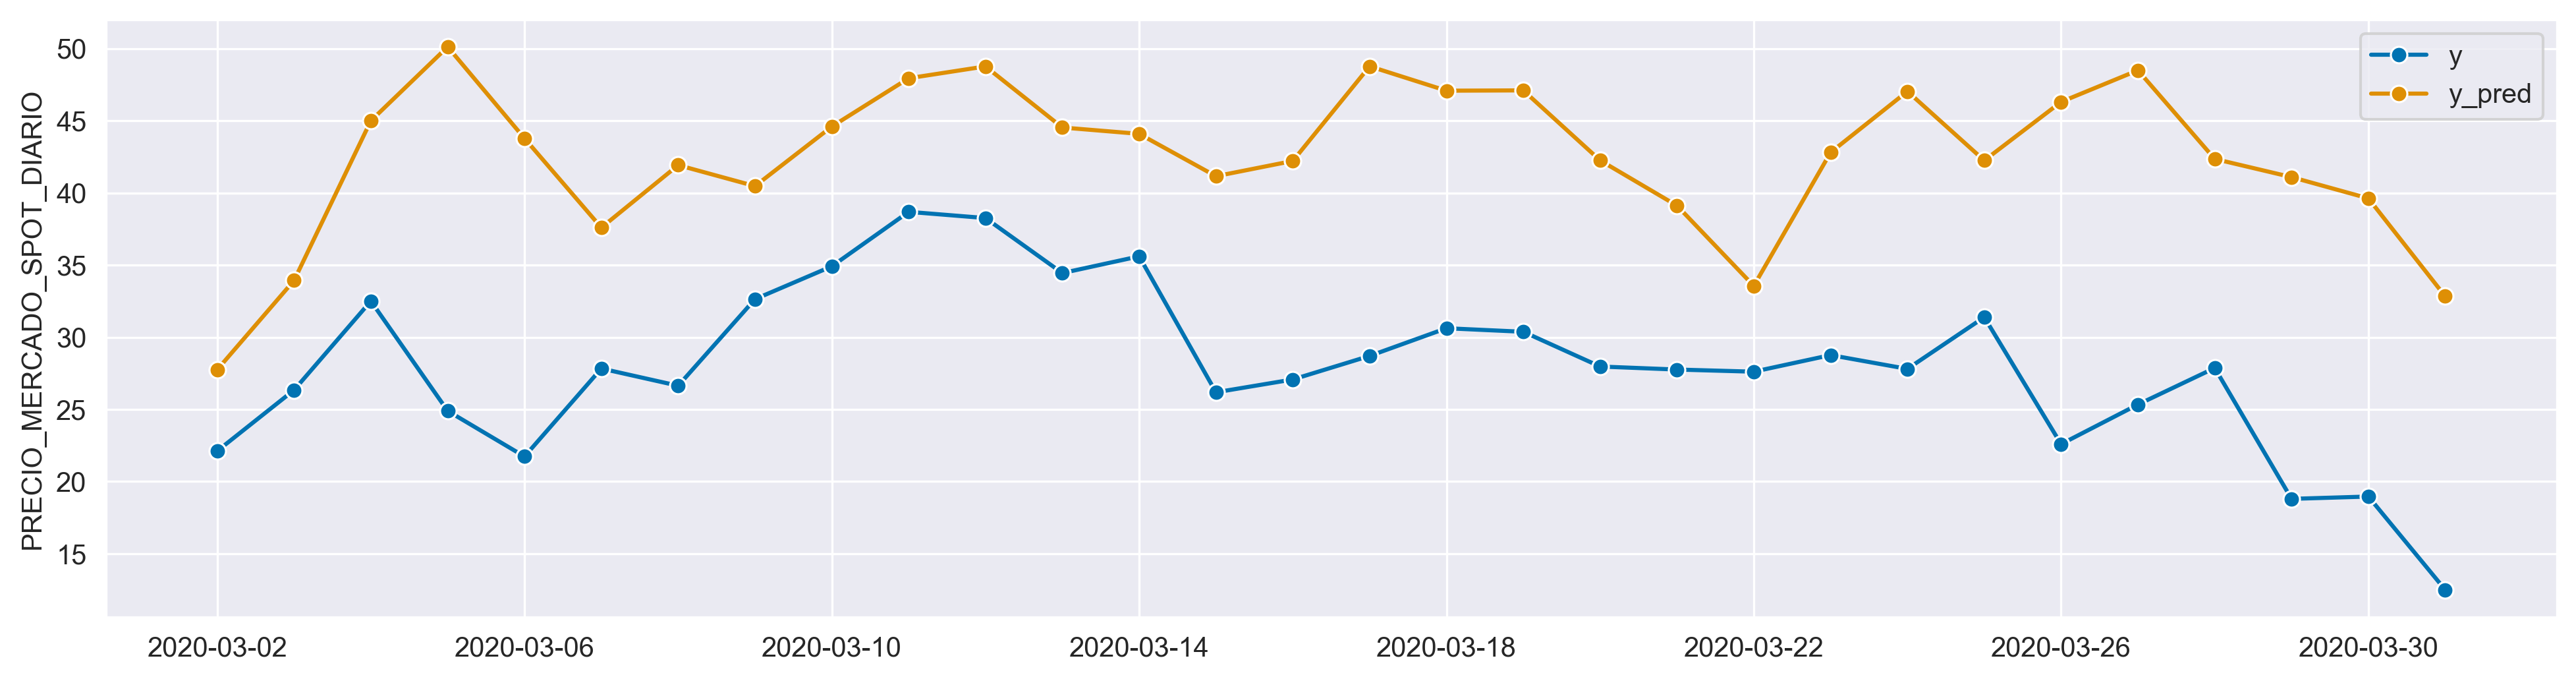

In [18]:
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]
# best_model = GradientBoostingRegressor(random_state=0)

forecaster = make_reduction(best_model, strategy="direct", window_length=1, windows_identical=True)
forecaster.fit(y_date_features_train, X=X_date_features_train, fh=list(range(1, forecasting_horizon + 1)))

y_pred = forecaster.predict(X=X_date_features_test)
plot_series(y_date_features_test, y_pred, labels=["y", "y_pred"])
print(mean_absolute_error(y_date_features_test, y_pred))
print(mean_absolute_percentage_error(y_date_features_test, y_pred))
print(mean_absolute_scaled_error(y_date_features_test, y_pred, y_train=y_date_features_train))

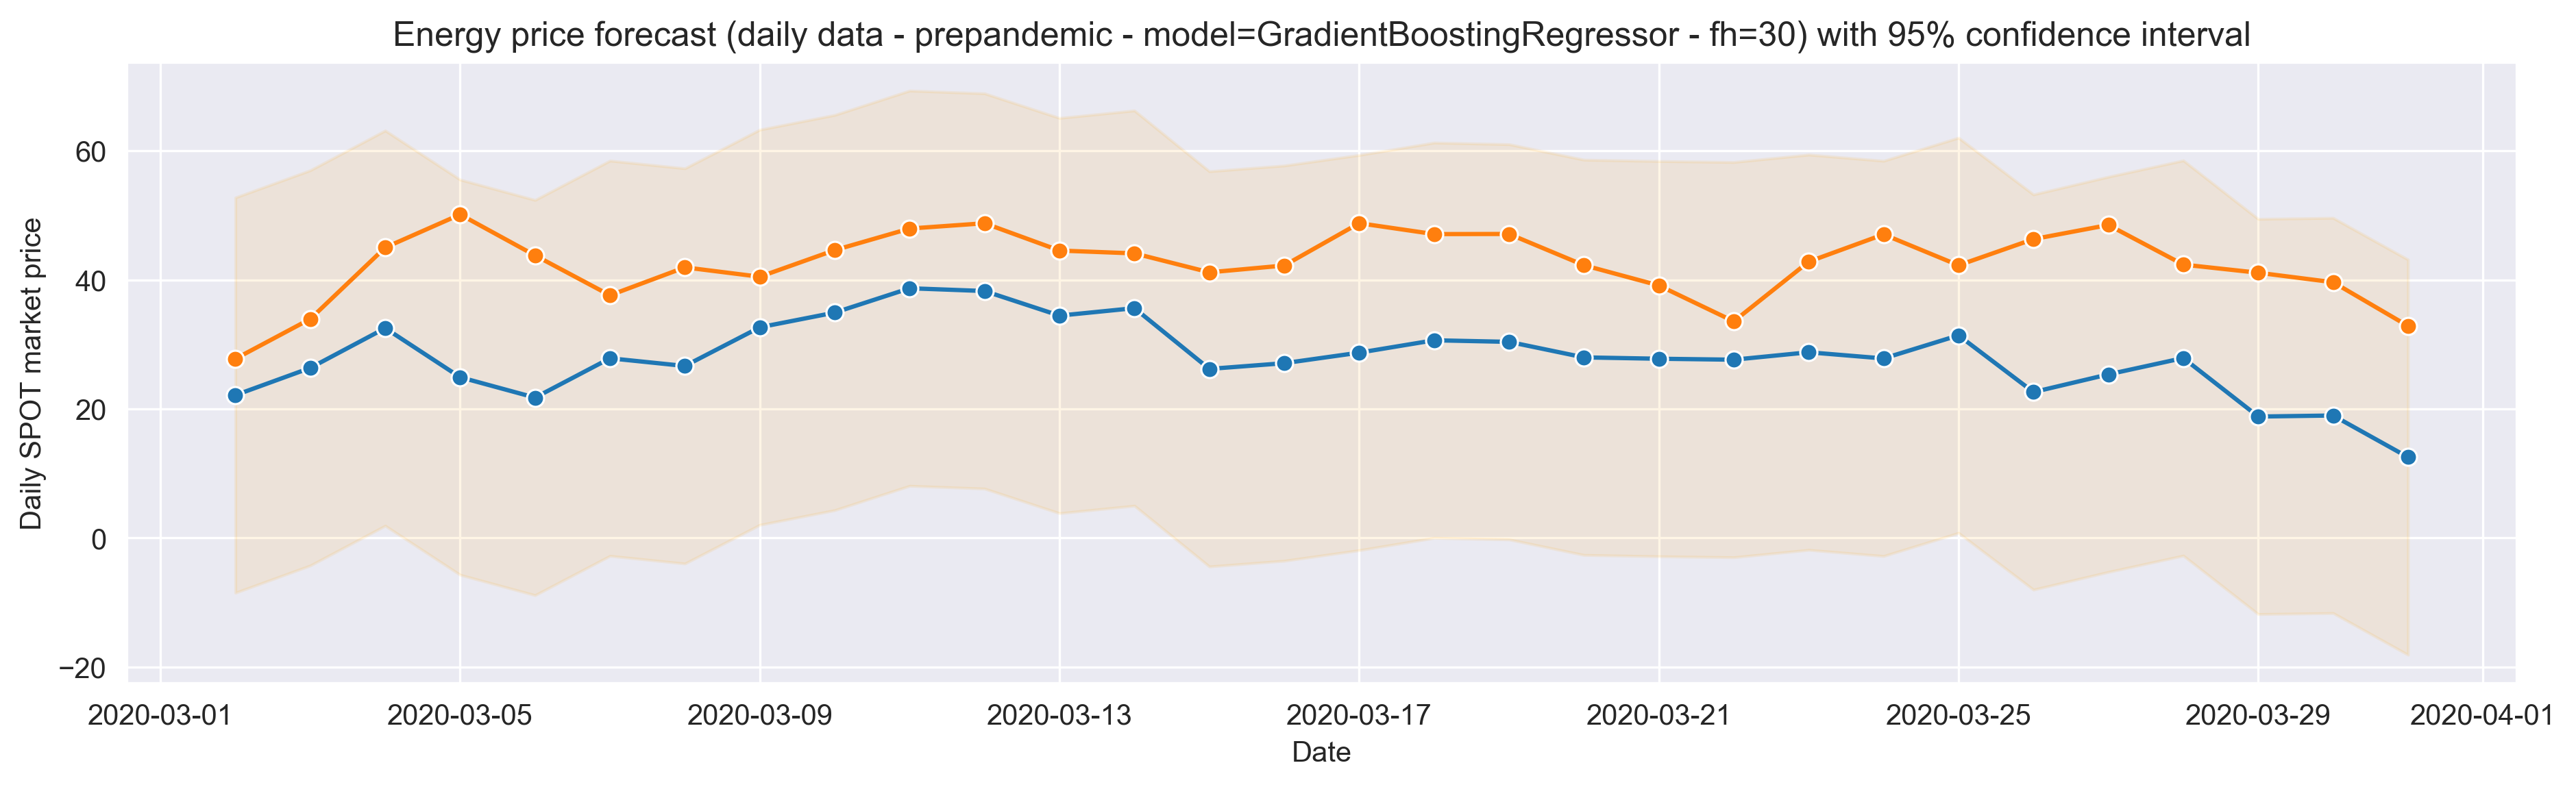

In [19]:
residuals = abs(y_pred-y_date_features_test)
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

if type(y_date_features_test.index) is pd.core.indexes.period.PeriodIndex:
    y_date_features_test.index = y_date_features_test.index.to_timestamp()
if type(y_pred.index) is pd.core.indexes.period.PeriodIndex:
    y_pred.index = y_pred.index.to_timestamp()

fig, ax = plt.subplots(figsize=(15,4 ))
sns.lineplot(data=y_date_features_test, palette="deepskyblue", marker="o", ax=ax)
sns.lineplot(data=y_pred, palette="orange", marker="o", ax=ax)
ax.fill_between(y_date_features_test.index, (y_date_features_test-band_size), (y_date_features_test+band_size), color='orange', alpha=.1)
ax.set_title(f"Energy price forecast (daily data - prepandemic - model={best_model_string} - fh={forecasting_horizon}) with 95% confidence interval")
ax.set_xlabel('Date')
ax.set_ylabel('Daily SPOT market price')
plt.show()

## Both combined

In [20]:
y_date_features_train, y_date_features_test, X_date_features_train, X_date_features_test, window_length = load_and_preprocess_daily_data(start_index="2017-04-01", end_index="2023-03-31")
print(window_length)

1907


In [21]:
cv_results_df = func.crossval_model_sktime(y_date_features_train, X_date_features_train, regressor_list, regressor_str_list, window_length, max_lag=1, step_size=step_size, fh=fh, save_path="lab/models/daily/", save_name="6y_20w_1step_30fh_9pred_mase_both_combined.pkl")

Training setup: regressor DummyRegressor
Training setup: regressor KNeighborsRegressor
Training setup: regressor RandomForestRegressor
Training setup: regressor GradientBoostingRegressor
Training setup: regressor SVR


In [22]:
save_path = "lab/models/daily/"
cv_results_df = pd.read_pickle(save_path+"6y_20w_1step_30fh_9pred_mase_both_combined.pkl")

In [23]:
cv_results_df_summary = func.crossval_summary_sktime(cv_results_df)
cv_results_df_summary

model          mae      mase     fit_time
3  GradientBoostingRegressor   894.393313  4.897767   696.383714
0             DummyRegressor   896.933962  4.907985     0.430406
2      RandomForestRegressor  1074.499536  5.892628  1388.050782
4                        SVR  1256.517692  6.872439   144.108247
1        KNeighborsRegressor  1354.044428  7.408178      0.93499

#### Final model

33.98536819978078
0.6104118075785278
3.675295585655341


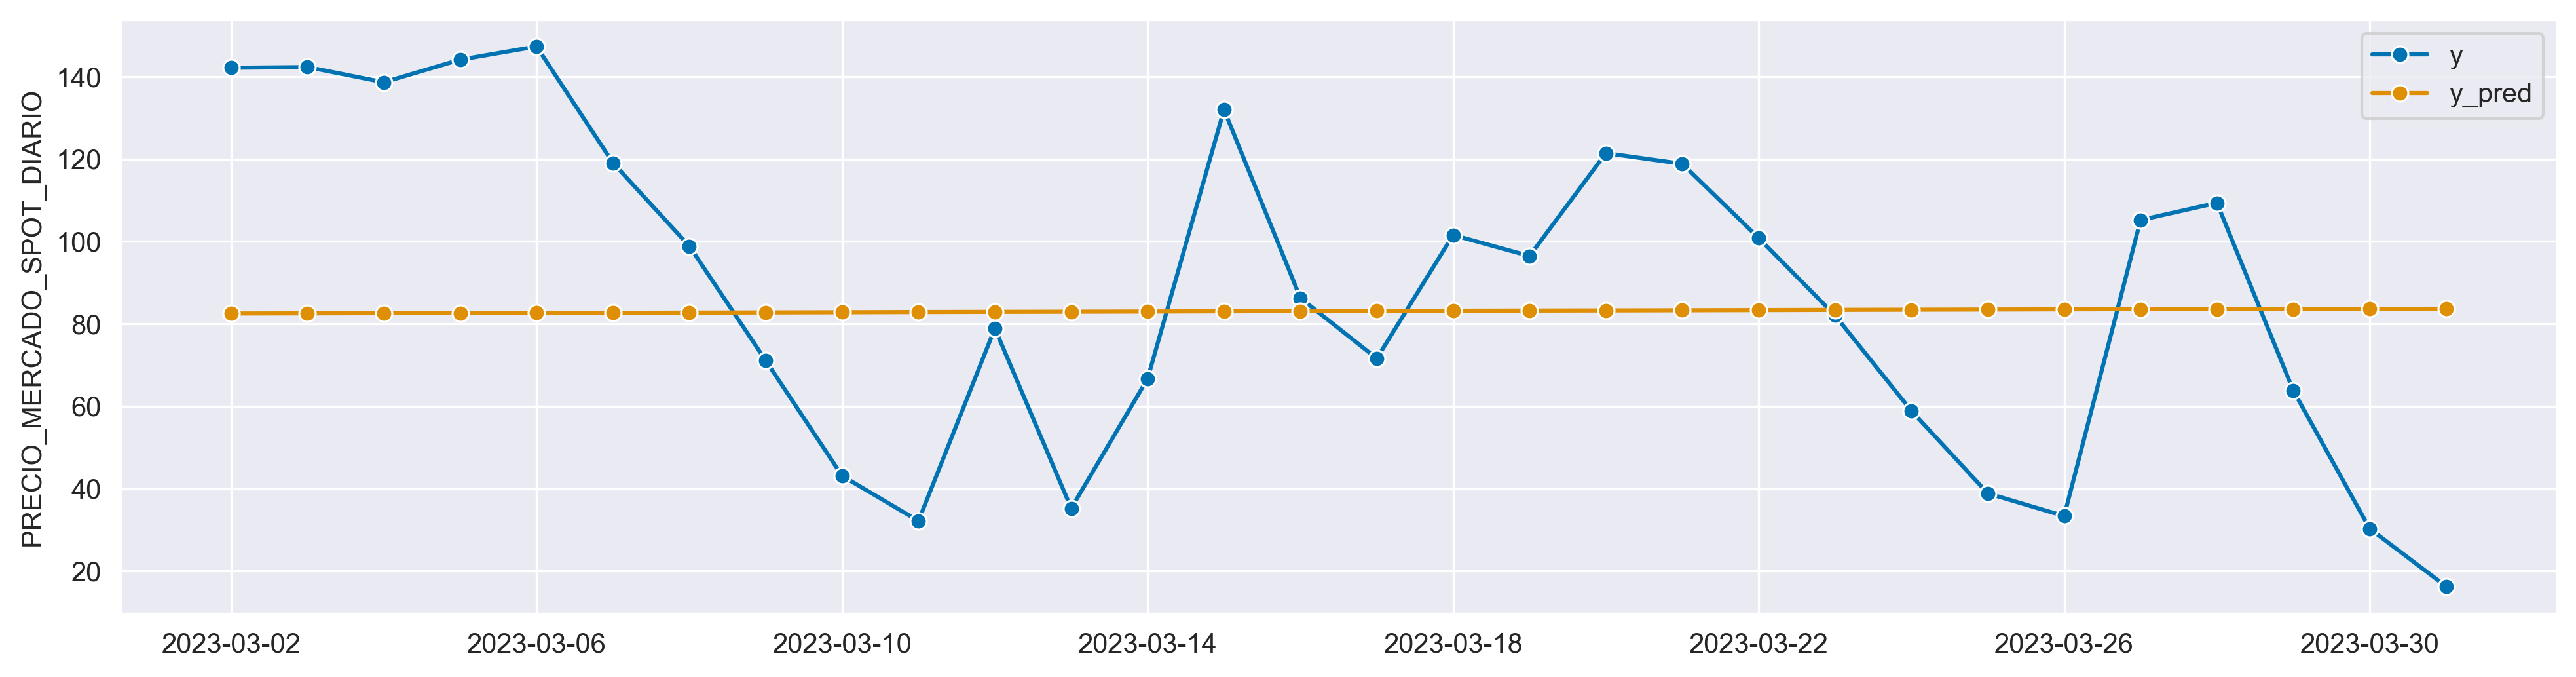

In [24]:
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]
# best_model = GradientBoostingRegressor(random_state=0)

forecaster = make_reduction(best_model, strategy="direct", window_length=1, windows_identical=True)
forecaster.fit(y_date_features_train, X=X_date_features_train, fh=list(range(1, forecasting_horizon + 1)))

y_pred = forecaster.predict(X=X_date_features_test)
plot_series(y_date_features_test, y_pred, labels=["y", "y_pred"])
print(mean_absolute_error(y_date_features_test, y_pred))
print(mean_absolute_percentage_error(y_date_features_test, y_pred))
print(mean_absolute_scaled_error(y_date_features_test, y_pred, y_train=y_date_features_train))

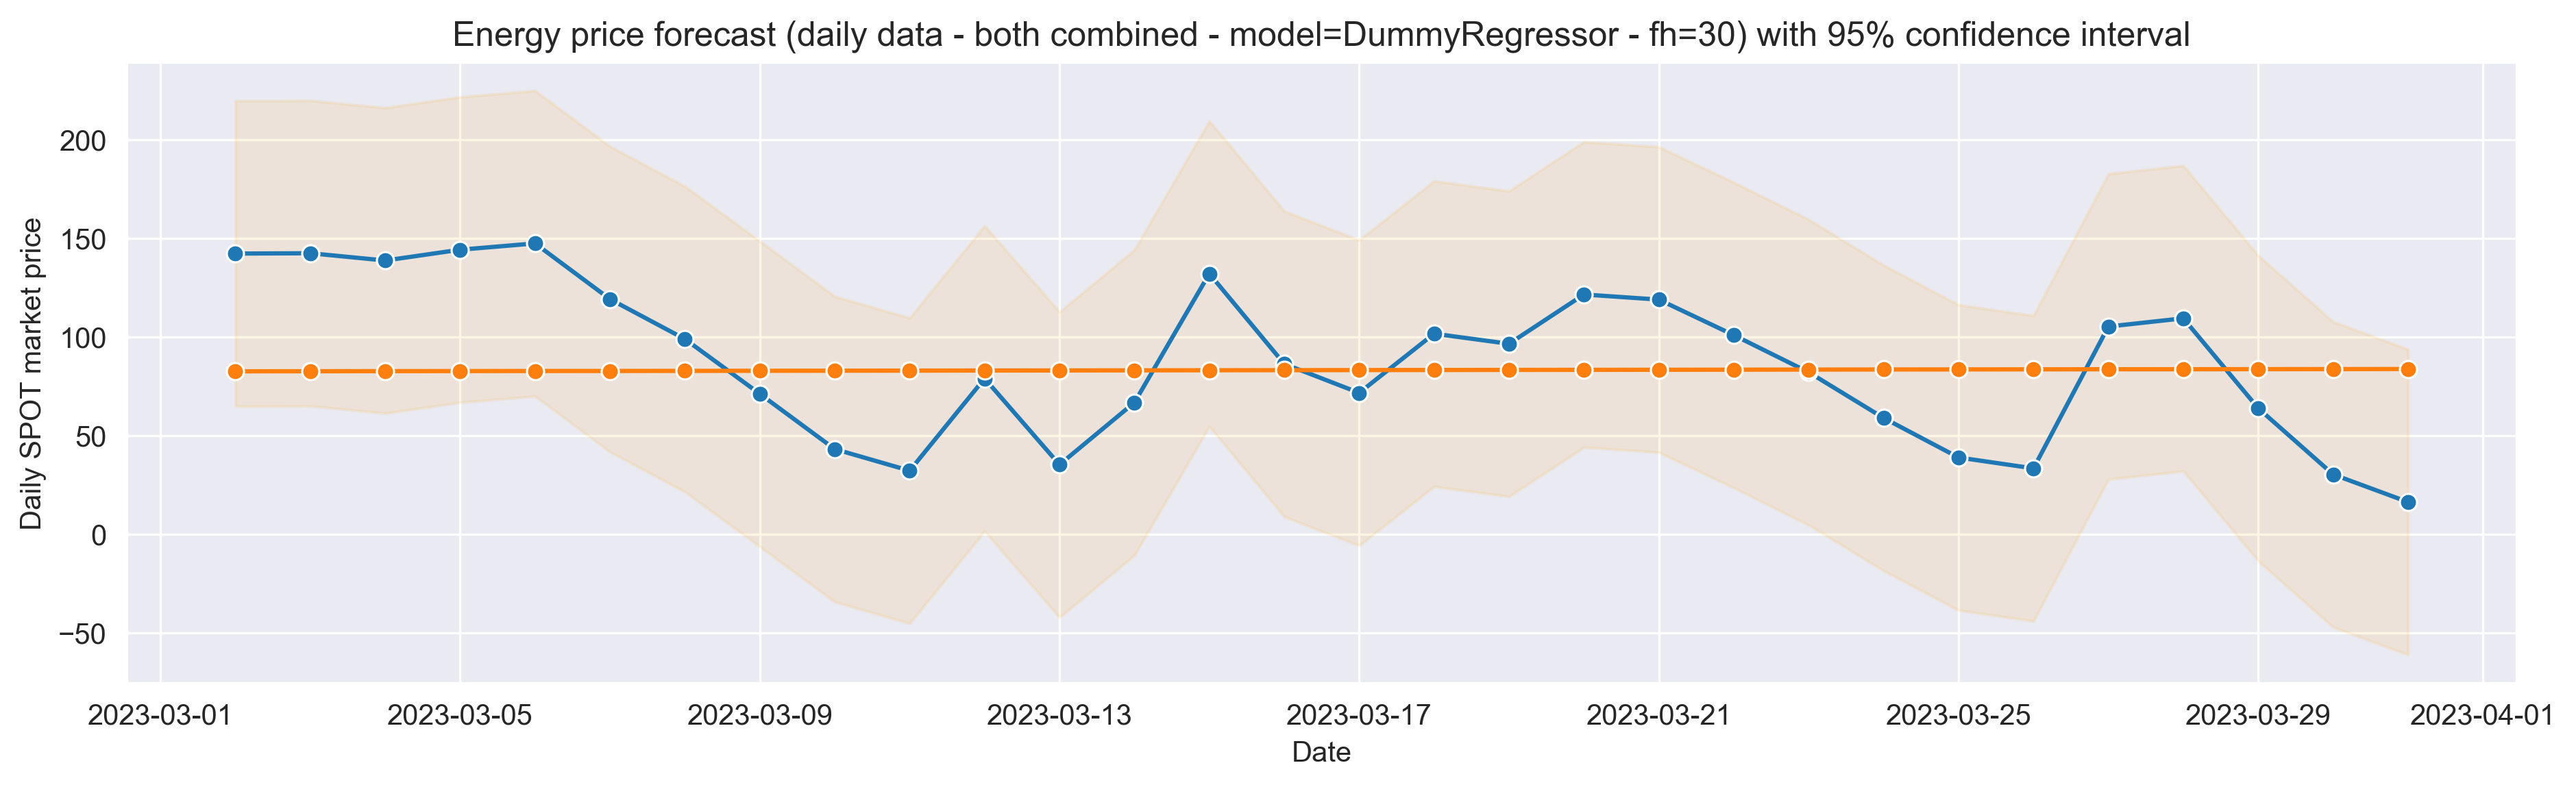

In [25]:
residuals = abs(y_pred-y_date_features_test)
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
band_size = 1.96*RMSFE

if type(y_date_features_test.index) is pd.core.indexes.period.PeriodIndex:
    y_date_features_test.index = y_date_features_test.index.to_timestamp()
if type(y_pred.index) is pd.core.indexes.period.PeriodIndex:
    y_pred.index = y_pred.index.to_timestamp()

fig, ax = plt.subplots(figsize=(15,4 ))
sns.lineplot(data=y_date_features_test, palette="deepskyblue", marker="o", ax=ax)
sns.lineplot(data=y_pred, palette="orange", marker="o", ax=ax)
ax.fill_between(y_date_features_test.index, (y_date_features_test-band_size), (y_date_features_test+band_size), color='orange', alpha=.1)
ax.set_title(f"Energy price forecast (daily data - both combined - model={best_model_string} - fh={forecasting_horizon}) with 95% confidence interval")
ax.set_xlabel('Date')
ax.set_ylabel('Daily SPOT market price')
plt.show()